In [ ]:
# For running code on the cloud w/o dependencies met
!pip install ipywidgets # Temporary workaround for Paperspace
!pip install -U scikit-image

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     |████████████████████████████████| 121 kB 22.8 MB/s eta 0:00:01
     |████████████████████████████████| 243 kB 74.8 MB/s eta 0:00:01
     |████████████████████████████████| 1.6 MB 100.3 MB/s eta 0:00:01
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     |████████████████████████████████| 60.7 MB 14.2 MB/s eta 0:00:01
     |████████████████████████████████| 178 kB 99.6 MB/s eta 0:00:01
     |████████████████████████████████| 1.9 MB 89.5 MB/s eta 0:00:01
     |████████████████████████████████| 6.3 MB 90.7 MB/s eta 0:00:01
     |████████████████████████████████| 3.3 MB 85.8 MB/s eta 0:00:01
     |████████████████████████████████| 3.1 MB 93.1 MB/s eta 0:00:01
  Attempting uninstall: pillow
    Found existing installation: Pillow 8.2.0
    Uninstalling Pillow-8.2.0:
      Successfully uninstalled Pillow-8.2.0
  Attempting uninstall: networkx
    Found existing installation: networkx 2.0


# Import Libraries

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

import os

import numpy as np
from models import *
from PIL import Image

import torch
import torch.optim
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True
dtype = torch.cuda.FloatTensor

# changed from skimage.measure.compare_psnr in recent versions of skikit-image
from skimage.metrics import peak_signal_noise_ratio, mean_squared_error
from utils.denoising_utils import *

# Constants
imsize =-1 # Image resize scaling, where -1 means no resize
sigma = 25 # Standard deviation of noise
once_every = 500
PLOT = True

import cv2 as cv

# Load Image

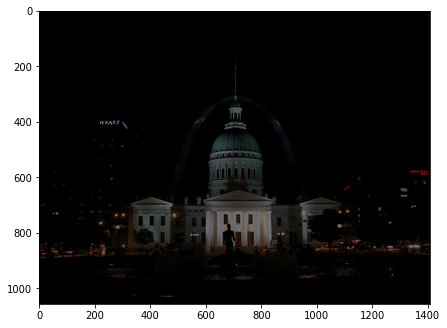

In [ ]:
fname = 'naive_dark_half.png' # Change as needed
# Load in PIL as well as numpy array versions of ground truth (GT) image
img_pil = crop_image(get_image(fname, imsize)[0], d=32)
img_np = pil_to_np(img_pil)
# Generate noisy image in PIL and numpy
plot_image_grid([img_np], 4, 6);

# Setup

In [ ]:
INPUT = 'noise' # 'meshgrid'
pad = 'reflection'
OPT_OVER = 'net' # 'net,input'

reg_noise_std = 1./30. # set to 1./20. for sigma=50
LR = 0.01

OPTIMIZER='adam' # 'LBFGS'
show_every = 500
exp_weight=0.99

num_iter = 10000
input_depth = 32 
figsize = 4 

net = get_net(input_depth, 'skip', pad,
                skip_n33d=128, 
                skip_n33u=128, 
                skip_n11=4, 
                num_scales=5,
                upsample_mode='bilinear').type(dtype)

net_input = get_noise(input_depth, INPUT, (img_pil.size[1], img_pil.size[0])).type(dtype).detach()

# Compute number of parameters
s  = sum([np.prod(list(p.size())) for p in net.parameters()]); 
print ('Number of params: %d' % s)

# Loss
mse = torch.nn.MSELoss().type(dtype)

img_torch = np_to_torch(img_np).type(dtype)

Number of params: 2217831


# Optimize

In [ ]:
net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()
out_avg = None
last_net = None
psrn_noisy_last = 0

# For analysis
iter_record = []
loss_record = []

i = 0
def closure():
    
    global i, out_avg, psrn_noisy_last, last_net, net_input
    
    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)
    
    out = net(net_input)
    
    # Smoothing
    if out_avg is None:
        out_avg = out.detach()
    else:
        out_avg = out_avg * exp_weight + out.detach() * (1 - exp_weight)
            
    total_loss = mse(out, img_torch)
    total_loss.backward()
    
    # Note that we do not have GT for the "snail" example
    # So 'PSRN_gt', 'PSNR_gt_sm' make no sense
    # print ('Iteration %05d    Loss %f   PSNR_noisy: %f   PSRN_gt: %f PSNR_gt_sm: %f' % (i, total_loss.item(), psrn_noisy, psrn_gt, psrn_gt_sm), '\r', end='')
    #if False && i % show_every == 0:
    #   out_np = torch_to_np(out)
    #    plot_image_grid([np.clip(out_np, 0, 1), 
    #                     np.clip(torch_to_np(out_avg), 0, 1)], factor=figsize, nrow=1)
    
    # Recording PSNR over time
    iter_record.append(i)
    loss_record.append(total_loss)
    
    # Print progress each show_every iterations, and also save image for reference
    if  PLOT and i % show_every == 0:
        out_np = torch_to_np(out)
        plot_image_grid([np.clip(out_np, 0, 1), 
                         np.clip(torch_to_np(out_avg), 0, 1)], factor=figsize, nrow=1)
       
        out_np_to_export = np.array([np.clip(torch_to_np(out), 0, 1)]).squeeze() * 255
        out_np_to_export = np.transpose(out_np_to_export, (1, 2, 0))
        cv.imwrite('deepprior_bright' + str(i) + '.png', cv.cvtColor(out_np_to_export, cv.COLOR_RGB2BGR))
        
    i += 1

    return total_loss

p = get_params(OPT_OVER, net, net_input)
optimize(OPTIMIZER, p, closure, LR, num_iter)

Starting optimization with ADAM
